# Gaussian Belief Propagation Using Markov Random Fields

In [1]:
%config InlineBackend.figure_format = 'svg'

from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

def print_deader(msg, msg_len=65, symbol='#'):
    print('\n' + symbol * msg_len + '\n' + symbol * msg_len + '\n')
    print(msg.center(msg_len))
    print('\n' + symbol * msg_len + '\n' + symbol * msg_len + '\n')

def print_step_summery(msg, msg_len=65):
    print('\n' + '_' * msg_len + msg + '‾' * msg_len + '\n')

In [2]:
class GraphGaBP:
    def __init__(self):
        self.nodes = []   # [0, 1, ...]
        self.edges = []   # [(0, 1), ...]

        self.nodes_count = 0
        self.edges_count = 0

        self.nodes_neighbors = {}   #   N(i) = {0: [1, ...]  , 1: [4, ...]  , ...}

        # elements of 𝜙ᵢ - ∝ N[μᵢᵢ, σᵢᵢ]
        self.p_ii = {}     # Pᵢᵢ = {0: P₀₀, 1: P₁₁, ...}
        self.mu_ii = {}    # μᵢᵢ = {0: μ₀₀, 1: μ₁₁, ...}

        # elements of mᵢⱼ(xⱼ) ∝ [μᵢⱼ, σᵢⱼ]
        self.p_ij = {}     # Pᵢⱼ = {0: {j: P₀ⱼ, ...}, 1: {j: P₁ⱼ, ...}, ...}
        self.mu_ij = {}    # μᵢⱼ = {0: {j: μ₀ⱼ, ...}, 1: {j: μ₁ⱼ, ...}, ...}

        # initialize a networkx graph object
        self.nx_graph = nx.Graph()

    def add_node(self):
        node_id = self.nodes_count
        self.nodes.append(node_id)
        self.nx_graph.add_node(node_id)
        self.nodes_neighbors[node_id] = []

        self.p_ii[node_id] = 0
        self.mu_ii[node_id] = 0

        self.p_ij[node_id] = {}
        self.mu_ij[node_id] = {}

        self.nodes_count += 1

    def add_edge(self, node1, node2):
        self.edges.append((node1, node2))
        self.nx_graph.add_edge(node1, node2)

        # adding edge between node1 and node 2 makes them neighbors
        self.nodes_neighbors[node1].append(node2)
        self.nodes_neighbors[node2].append(node1)

        # initialize messages mᵢⱼ(xⱼ) ∝ [μᵢⱼ, σᵢⱼ] with Pᵢⱼ = 0
        self.p_ij[node1][node2] = 0
        self.p_ij[node2][node1] = 0

        # initialize messages mᵢⱼ(xⱼ) ∝ [μᵢⱼ, σᵢⱼ] with μᵢⱼ = 0
        self.mu_ij[node1][node2] = 0
        self.mu_ij[node2][node1] = 0

        self.edges_count += 1

    def show_graph(self):
        """Display a plot to visualize the graph"""
        nx.draw(self.nx_graph, with_labels=True, node_size=500,node_color='pink',alpha=0.9)
        plt.show()

    def print_graph_state(self, raw_data=True):
        """Prints detailed information about the parameters of this class

        Parameters
        ----------
        raw_data: bool
            if True, show the data in it's raw format as it appear in the class (useful in order
            to see how each parameter represented in this class).
            if False, show the data in a table (useful for actual analysis on the algorithm).

        """
        if raw_data:
            print(f'Nodes: {self.nodes}')
            print(f'Edges: {self.edges}')
            print(f'Nodes neighbors: {self.nodes_neighbors}')
            print(f'p_ii:  {self.p_ii}')
            print(f'μ_ii:  {self.mu_ii}')
            print(f'p_ij:  {self.p_ij}')
            print(f'μ_ij:  {self.mu_ij}')
        else:
            graph_state = []
            graph_state_columns = ['Node i',
                                   'Neighbors N(i)',
                                   'Pᵢᵢ',
                                   'μᵢᵢ',
                                   'Pᵢⱼ',
                                   'μᵢⱼ']
            for node in self.nodes:
                graph_state.append([node,
                                    self.nodes_neighbors[node],
                                    self.p_ii[node],
                                    self.mu_ii[node],
                                    self.p_ij[node],
                                    self.mu_ij[node]])

            print(tabulate(graph_state, headers=graph_state_columns, numalign='center', stralign='center'))

- Elements with $\textbf{A}_{ij} \neq 0$ represent an edge in the graph.
- Using $\textbf{A}$, initialize a graph.

## Graph Input

- $\textbf{A}$ - a data matrix
- $\textbf{b}$ - observation vector

In [3]:
# define number of nodes for the graph
graph_dim = 4

# Get A
A = np.random.randn(graph_dim, graph_dim)
A = np.abs(A)
A_mask = [[1, 1, 0, 0], [1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 0, 1]]
A = A_mask * A
A = A / np.sum(A)
print('A:')
print(A)

# get b
b = np.random.randn(4, 1)
b = np.abs(b)
b = b / np.sum(b)
print('\nb:')
print(b)

A:
[[0.19413462 0.13871852 0.         0.        ]
 [0.0012556  0.04850503 0.11419964 0.2397744 ]
 [0.         0.16851675 0.05163666 0.        ]
 [0.         0.00078412 0.         0.04247466]]

b:
[[0.03526224]
 [0.5673085 ]
 [0.26971128]
 [0.12771798]]


## Build the Graph and Display it

### Initialize the Free Parameters

- Define: $P_{ii}^{-1} \equiv \sigma _{ii}$
- Define $N\left ( i \right ) = \left \{ k | k\neq i, A_{ki} \neq 0 \right \}$
- Initialize $P_{ii}^{t=0}=A_{ii}$ and $\mu_{ii}^{t=0}=\frac{b_i}{A_{ii}}$ to get the initialized node potential:
$ \phi_i^{t=0}\left ( x_i \right )\propto {N}\left ( \mu_{ii}=\frac{b_i}{A_{ii}}, P_{ii}^{-1}=A_{ii}^{-1} \right )  $
- Initialize $P_{ki}^{t=0}=0$ and $\mu_{ki}^{t=0}=0$ to get the initialized messages: $m_{ij}^{t=0}\left ( x_{j} \right ) \propto N\left ( \mu_{ij}, P_{ij}^{-1} \right )$

In [4]:
def construct_graph(A: np.ndarray, b: np.ndarray):
    """
    Initialize a graph object given data matrix A and the observation vector b
    """
    # initialize a graph object
    graph = GraphGaBP()

    # the data matrix A defines the number of nodes
    number_of_nodes = A.shape[0]

    # Define a graph with 4 nodes
    for i in range(number_of_nodes):
        graph.add_node()

    # add nodes where A_ij != 0
    for i in range(number_of_nodes):
        for j in range(number_of_nodes):
            if (i > j) & (A[i][j] > 0):
                graph.add_edge(i, j)

    # Initialize node potentials - 𝜙ᵢ ∝ N[μᵢᵢ, σᵢᵢ] (note that σᵢᵢ = Pᵢᵢ⁻¹)
    for i in range(number_of_nodes):
        graph.p_ii[i] = A[i][i]               # Pᵢᵢ = Aᵢᵢ
        graph.mu_ii[i] = b[i][0] / A[i][i]    # μᵢᵢ = bᵢ / Aᵢᵢ

    return graph

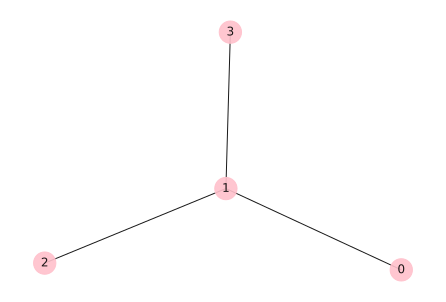

In [5]:
graph = construct_graph(A, b)
graph.show_graph()

## Display Raw Data of the Graph State

In [6]:
graph.print_graph_state()

Nodes: [0, 1, 2, 3]
Edges: [(1, 0), (2, 1), (3, 1)]
Nodes neighbors: {0: [1], 1: [0, 2, 3], 2: [1], 3: [1]}
p_ii:  {0: 0.19413461850487582, 1: 0.04850502899607877, 2: 0.05163665940575841, 3: 0.04247465965252306}
μ_ii:  {0: 0.18163806511357639, 1: 11.695869736182873, 2: 5.223251903925796, 3: 3.0069218759289056}
p_ij:  {0: {1: 0}, 1: {0: 0, 2: 0, 3: 0}, 2: {1: 0}, 3: {1: 0}}
μ_ij:  {0: {1: 0}, 1: {0: 0, 2: 0, 3: 0}, 2: {1: 0}, 3: {1: 0}}


## Display the Graph State in a Table

In [7]:
graph.print_graph_state(raw_data=False)

 Node i    Neighbors N(i)      Pᵢᵢ       μᵢᵢ            Pᵢⱼ                 μᵢⱼ
--------  ----------------  ---------  --------  ------------------  ------------------
   0            [1]         0.194135   0.181638        {1: 0}              {1: 0}
   1         [0, 2, 3]      0.048505   11.6959   {0: 0, 2: 0, 3: 0}  {0: 0, 2: 0, 3: 0}
   2            [1]         0.0516367  5.22325         {1: 0}              {1: 0}
   3            [1]         0.0424747  3.00692         {1: 0}              {1: 0}


## Run GaBP Algorithm

In order to propagate the messages through the graph, two scalars $P_{ij}$ and $\mu _{ij}$ can be used to update the message.

The message is than given by: $m_{ij}\left ( x_{j} \right ) \propto N\left ( \mu_{ij}, P_{ij}^{-1} \right )$
1. Find $P_{ij}$:
    1. $P_{i\setminus j} = P_{ii} + \sum _ {k \in N\left ( i \right )\setminus j} P_{ki}$
    1. $P_{ij} = -A_{ij}^2 P_{i\setminus j}^{-1}$
1. Find $\mu _{ij}$:
    1. $\mu_{i\setminus j} = P_{i\setminus j}^{-1} \left ( P_{ii} \mu_{ii} + \sum _ {k \in N\left ( i \right )\setminus j} P_{ki} \mu_{ki} \right ) $
    1. $\mu _{ij}=-P_{ij}^{-1} A_{ij} \mu_{i\setminus j}$

### Helper functions for the GaBP iteration function

In [8]:
def get_graph_state(g, print_state=False):
    """return the graph's Pᵢⱼ and μᵢⱼ at the time calling the function

     Parameters
     ----------
     g: GraphGaBP
        A GaBP graph object at a given time
    print_state: bool
        choose if to print the current state of the graph

    Returns
    -------
    graph_state: list
        the state of the graph in the format of: [[node: int, [Pᵢⱼ list]: list, [μᵢⱼ list]: list],
                                                  [node: int, [Pᵢⱼ list]: list, [μᵢⱼ list]: list], ...]
    """
    graph_state = []
    for node in g.nodes:
        graph_state.append([node,
                            list(g.p_ij[node].values()),
                            list(g.mu_ij[node].values())])
    if print_state:
        print(tabulate(graph_state, headers=['Node', 'Pᵢⱼ', 'μᵢⱼ']))
    return graph_state

def l2(a, b):
    """find l2 distance between two vectors"""
    a = np.array(a)
    b = np.array(b)
    return np.power(np.sum(np.power(a - b, 2)), 1/2)

def calc_iteration_l2(before_state, after_state):
    # calc the l2 distance between Pᵢⱼ and μᵢⱼ at each node
    nodes_p_l2 = []
    nodes_mu_l2 = []
    for before, after in zip(before_state, after_state):
        p_before = before[1]
        mu_before = before[2]
        p_after = after[1]
        mu_after = after[2]

        p_l2 = l2(p_before, p_after)
        mu_l2 = l2(mu_before, mu_after)

        nodes_p_l2.append(p_l2)
        nodes_mu_l2.append(mu_l2)
    total_distance = np.sum(nodes_p_l2) + np.sum(nodes_mu_l2)
    return nodes_p_l2, nodes_mu_l2, total_distance

### One iteration of the GaBP algorithm

- The function `run_GaBP_iteration` accepts a boolean variable `show_intermediate_result`.
  Setting it to `True` prints the graph state as the GaBP algorithm travels through the nodes in the graph
  and can be useful for debugging and further analysis.

In [9]:
def run_GaBP_iteration(graph, A, show_intermediate_result = False):
    """Run the GaBP algorithm on a given graph for one iteration

    Parameters
    ----------
    graph: GraphGaBP
        A GaBP graph object at a given time
    A: np.ndarray
        The data matrix
    show_intermediate_result: bool
        choose if to print the state of the graph during it's running

    Returns
    -------
    graph: GraphGaBP
        A GaBP graph object after running the GaBP algorithm on it
    before_state: list
        Pᵢⱼ and μᵢⱼ of the graph before the GaBP iteration
    after_state: list
        Pᵢⱼ and μᵢⱼ of the graph after the GaBP iteration
    """
    # get the Pᵢⱼ and μᵢⱼ of the graph before the GaBP iteration
    # print('Before graph state:')
    before_state = get_graph_state(graph, print_state=False)

    # run the GaBP algorithm for one iteration
    for i in graph.nodes:
        p_ii = graph.p_ii[i]
        mu_ii = graph.mu_ii[i]
        p_ij = graph.p_ij[i]
        mu_ij = graph.mu_ij[i]
        N_i = graph.nodes_neighbors[i]
        if show_intermediate_result:
            print(f'\nCurrent Node: i={i}')
            print(f'   N(i) = {N_i}')
            print(f'   Pᵢᵢ = {np.round(p_ii, 4)}')
            print(f'   μᵢᵢ = {np.round(mu_ii, 4)}')
            print(f'   Pᵢⱼ = {p_ij}')
            print(f'   μᵢⱼ = {mu_ij}')
        for j in N_i:
            # n(i)\j
            N_ij = [k for k in N_i if k != j]

            ###################################################################
            #                          Get Updated Pᵢⱼ
            ###################################################################

            # initialize P_i\j = p_ii
            p_N_ij = p_ii

            # P_i\j = p_ii + ∑_{k ∈ n(i)\j} Pₖᵢ
            for k in N_ij:
                p_ki = graph.p_ij[k][i]
                p_N_ij += p_ki

            # Pᵢⱼ = -Aᵢⱼ^2 * P_i\j^(-1)
            p_ij = -1 * A[i][j] * A[j][i] / p_N_ij

            # update new values to the class
            graph.p_ij[i][j] = p_ij

            ###################################################################
            #                          Get Updated μᵢⱼ
            ###################################################################

            # initialize μ_i\j = 0
            mu_N_ij = 0

            # ∑_{k ∈ n(i)\j} Pₖᵢμₖᵢ
            p_mu_N_ij = 0
            for k in N_ij:
                p_ki = graph.p_ij[k][i]
                mu_ki = graph.mu_ij[k][i]
                p_mu_N_ij += p_ki * mu_ki

            # μ_i\j = P_i\j ^ (-1)  * (p_ii*μ_ii + ∑_{k ∈ n(i)\j} Pₖᵢμₖᵢ)
            mu_N_ij = (1 / p_N_ij) * (p_ii*mu_ii + p_mu_N_ij)

            # μᵢⱼ = -Pᵢⱼ^(-1)*Aᵢⱼ*μ_i\j
            mu_ij = -1/p_ij * A[j][i] * mu_N_ij

            # update new values to the class
            graph.mu_ij[i][j] = mu_ij


            if show_intermediate_result:
                print(f'      Current j: {j}')
                print(f'         N(i)\j: {N_ij}')
                print(f'         P_i\j: {np.round(p_N_ij, 4)}')
                print(f'         μ_i\j: {np.round(mu_N_ij, 4)}')
                print('')

    # get the Pᵢⱼ and μᵢⱼ of the graph before the GaBP iteration
    # print('\nAfter graph state:')
    after_state = get_graph_state(graph, print_state=False)

    return graph, before_state, after_state

### Run the GaBP for certain amount of iterations

In [10]:
show_intermediate_result = False
if not show_intermediate_result:
    print("Note".center(65, "_"))
    print('If you want to see the intermediate results, set the variable in\nthe code above to True')
    print('‾'*65 + '\n')


print_deader('Run Gaussian Belief Propagation Algorithm')

# run GaBP until convergence/maximum iterations
max_iterations = 50
iteration_distance = []
for iteration in range(max_iterations):
    graph, before_state, after_state = run_GaBP_iteration(graph, A, show_intermediate_result)
    nodes_p_l2, nodes_mu_l2, total_distance = calc_iteration_l2(before_state, after_state)

    iteration_distance.append(total_distance)

    print('Nodes Pᵢⱼ L2 distance:\n' + f'{np.round(nodes_p_l2, 3)}'.center(65))
    print('Nodes μᵢⱼ L2 distance:\n' + f'{np.round(nodes_mu_l2, 3)}'.center(65))
    # print(f'Nodes μᵢⱼ L2 distance: {np.round(nodes_mu_l2, 3)}')

    # early stopping
    convergence_threshold = 1e-5
    if total_distance < convergence_threshold:
        print_step_summery(f'=> Converged on iteration {iteration}')
        break
    else:
        print_step_summery(f'=> Finished Iteration: {iteration}\n   Total L2 distance: {total_distance}')


_______________________________Note______________________________
If you want to see the intermediate results, set the variable in
the code above to True
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


#################################################################
#################################################################

            Run Gaussian Belief Propagation Algorithm            

#################################################################
#################################################################

Nodes Pᵢⱼ L2 distance:
                    [0.001 0.404 0.373 0.004]                    
Nodes μᵢⱼ L2 distance:
        [2.54000e-01 4.51858e+02 1.60100e+00 1.62880e+02]        

_________________________________________________________________
=> Finished Iteration: 0
   Total L2 distance: 617.3746532752185
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾

Nodes Pᵢⱼ L2 distance:
                    [0.    0.042 0.    0.   ]

## Infer and Compare with Analytic Result

### Exact solution

- The analytic result for the marginal densities should be a Gaussian (eq. 2.3, p. 9):
$p\left ( x_i \right )\sim N\left ( \mu_i=\left \{ \mathbf{A}^{-1}\textbf{b} \right \}_i,P_i^{-1}=\left \{ \mathbf{A}^{-1} \right \}_{ii} \right )$


In [11]:
def calc_exact_distribution(A, b):
    mu = linalg.inv(A) @ b
    sigma = linalg.inv(A)
    return mu, sigma

exact_mu, exact_sigma = calc_exact_distribution(A, b)
print('Exact μ:')
print(exact_mu)

print('Exact σ')
print(exact_mu)

Exact μ:
[[-1.44560708]
 [ 2.27730667]
 [-2.20876091]
 [ 2.96488058]]
Exact σ
[[-1.44560708]
 [ 2.27730667]
 [-2.20876091]
 [ 2.96488058]]


### GaBP Solution

- The probabilistic solution from the GaBP given by:
    - Marginal precisions - $P_i^{\text{GaBP}} = P_{ii}+  \sum_{k \in N\left ( i \right )} P_{ki} $
    - Marginal means -  $\mu_i^{\text{GaBP}} = \frac{P_{ii}\mu_{ii}+  \sum_{k \in N\left ( i \right )} P_{ki}\mu_{ki}}{P_i}$

In [12]:
def calc_node_marginal(graph, i):
    N_i = graph.nodes_neighbors[i]
    p_ii = graph.p_ii[i]
    mu_ii = graph.mu_ii[i]

    # Pᵢ
    marginal_precision = (p_ii + np.sum([graph.p_ij[k][i] for k in N_i]))

    # μᵢ
    marginal_mean = np.sum([graph.p_ij[k][i] * graph.mu_ij[k][i] for k in N_i]) +  p_ii*mu_ii
    marginal_mean = marginal_mean / marginal_precision

    return marginal_mean, marginal_precision

### Compare GaBP with exact solution

- For tree graph, the following should hold:
    - $P_i^{\text{GaBP}} = \frac{1}{\left \{ \mathbf{A}^{-1} \right \}_{ii}}$
    - $\mu_i^{\text{GaBP}} = \left \{ \mathbf{A}^{-1}\textbf{b} \right \}_i$

In [13]:
print_deader('Calculate Marginals')

for i in graph.nodes:
    marginal_mean, marginal_precision = calc_node_marginal(graph, i)

    print(f'Node {i}:\n‾‾‾‾‾‾‾')
    print(' '*4, f'μ:   Exact      : {exact_mu[i][0]}')
    print(' '*4, f'     Calculated : {marginal_mean}')
    print(' '*4, f'P:   Exact      : {1 / exact_sigma[i][i]}')
    print(' '*4, f'     Calculated : {marginal_precision}')


#################################################################
#################################################################

                       Calculate Marginals                       

#################################################################
#################################################################

Node 0:
‾‾‾‾‾‾‾
     μ:   Exact      : -1.4456070827692173
          Calculated : -1.4456070827692171
     P:   Exact      : 0.19466464713768308
          Calculated : 0.19466464713768308
Node 1:
‾‾‾‾‾‾‾
     μ:   Exact      : 2.277306669191836
          Calculated : 2.277306669191836
     P:   Exact      : -0.329510277043624
          Calculated : -0.32951027704362396
Node 2:
‾‾‾‾‾‾‾
     μ:   Exact      : -2.208760910344183
          Calculated : -2.2087609103441803
     P:   Exact      : -0.3940312030964156
          Calculated : -0.3940312030964156
Node 3:
‾‾‾‾‾‾‾
     μ:   Exact      : 2.9648805808558083
          Calculated : 2.964880580855808
     P: 